# Demo2: Legionella Dot protein comparison against AFDB2

## ISS_ProtSci: Query pruning and parameter tuning
ISS_ProtSci was run using PDB entry 9b8e as input. ISS_ProtSci automatically evaluates recall against the most highly scoring Pfam clan. 
In this case, the reference clan is CL0125. The query structure was pruned in three stages to obtain satisfactory recall. 

1. The first ISS_ProtSci run with the full PDB entry showed a large number of AFDB2 proteins matching to two helices in the region 118-154. 
These two helices, together with the N-terminal helix, form a helical layer that is structurally separate from the main alpha/beta-domain.

2. The second run excluded residues 118-154 from the query structure. ISS_ProtSci with default parameters still gave unsatisfactory recall.

3. The third run used a smaller minlali parameter, which is the minimum alignment (size of the "common core") that ISS_ProtSci should find. Setting minlali to 80 gave satisfactory recall. This result set is used in this demonstration.

Diagonsotics for satisfactory recall are that TP_1 is close to TRUE_1 and TP_2 is close to TRUE_2. The TRUE set contains proteins that belong to the Pfam class (CL0125) and TP are true positives. Suffix _1 refers to hits that have detectable structural similarity according to DALI (Z-score > 2). Suffix _2 refers to hits that additionally have DALI alignment lengths greater than minlali. P_2 close to TRUE_2 indicates high precision with respect to the reference classification. TRUE_2 near TRUE_1 indicates appropriate alignment length cutoff (minlali).


Note: It may seem surprising that the first experiment yields fewer TRUE_1 cases than the second and third. This is because TRUE_1 hits are filtered based on the DALI
Z-score, which is influenced by domain size: larger domains require a higher raw similarity score to achieve the same Z-score threshold.

## Prepare environment

In [1]:
%pip install -e .. -q
%pip install -e "..[visualization]" -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import os
import pandas as pd
# Add the repo root to the Python path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
# ISS_tools
import ISS_tools.visual  # read_tsv, diff_df, msa, read_dali_tsv, write_FASTA
import ISS_tools.Pfam    # Pfam
import ISS_tools.helpers # fit_line
# Reference classification (Pfam database)
pf=ISS_tools.Pfam.Pfam('../pfamdata')
pf.load_TRUE('../pfamdata/DaliDigest.clan_hmmer_tc.tsv')

## User inputs
The inputs to ISS_tools are output files generated by ISS_ProtSci. tsvfile is the search result. TRUE_CLAN_DALI_TSV is the TRUE_1 set. 

In [3]:
# ISS_ProtSci outputs
tsvfile='../demo_data/pr80A.AFDB2.pf.tsv' 
TRUE_CLAN_DALI_tsv='../demo_data/pr80A.CL0125.TRUE.dali.tsv'

## Load Query 
ISS_ProtSci search results are loaded to a DALIFrame object, which is a Pandas DataFrame with custom methods. 

The grouplabel method keeps the k most frequent classes in labelin and pools the rest into class 'other', writing these to labelout.

In [4]:
# load input tsvfile to a DALIFrame object with custom methods
df=ISS_tools.visual.read_tsv(tsvfile)
# reduce number of labels
df.grouplabel(k=5,labelin='pfam',labelout='family')
df.grouplabel(k=5,labelin='clan',labelout='superfamily')
#df.dtypes

assign unassigned
assign PF04473
assign PF13369
assign PF14822
assign PF05053
assign unassigned
assign CL0125
assign PF07906
assign PF19468


# View distribution of data points in (z-score, ali-length) plane
method df.scatter() uses matplotlib. The plot area can be selected with left, right, bottom, top parameters.

method df.iscatter() uses Plotly to generate an interactive scatterplot with zooming and hovertext.

df.scatter() and df.iscatter() accept optional color, marker and title parameters. hoertext is optional in df.iscatter() 

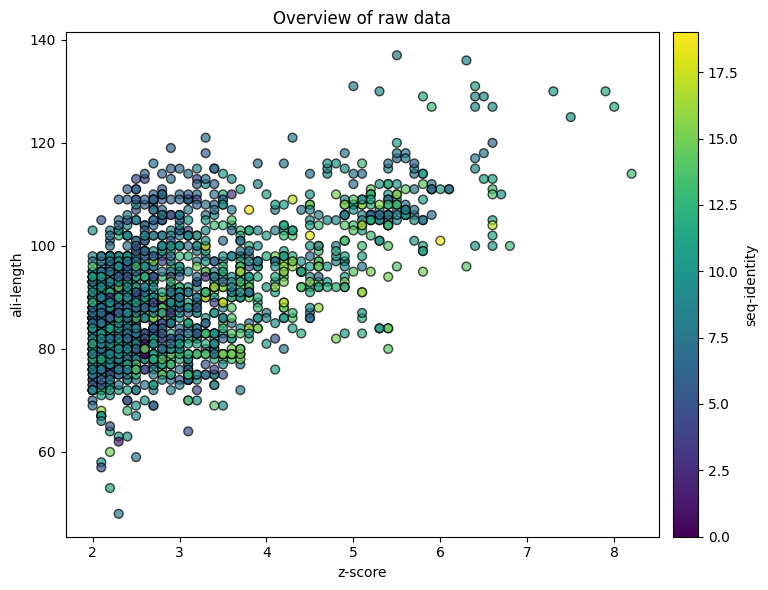

In [5]:
df.scatter(color='seq-identity',title='Overview of raw data')

Sequence identities (<20%) and Z-scores (<8) are relatively low. The Query structure is not closely related to any structure AFDB2.

# Partial Pfam family/clan annotations
ISS_ProtSci annotates the structurally aligned segments by running hmmsearch against the Pfam library. This gives an indication of what domains are present in the hits, although the use of fragment sequences misses some matches compared to hmmsearch using the full protein sequences. 

In [6]:
df.iscatter(color='superfamily',marker='family',hovertext='hovertext', title='Pfam annotations of structurally equivalent fragments')

The hits are dominated by clan CL0125 (green) and by fragments that did not yield Pfam matches above the trusted cutoff. Two families, colored in orange and cyan, stand out from the background. They exhibit structural similarity in the range observed for CL0125 members, but they are not—yet—classified as members.

# Using reference classification
Now that we have identified CL0125 as the "home" of our Query, let's complement clan assignments based on Pfam's hmmsearch against full protein sequences. Pfam assignments in df['pfam'] and df['clan'] were based on structurally aligned fragments, which is less sensitive.

Full protein based Pfam annotations are written to df['TRUE'].

In [7]:
# interactive scatterplot with zooming, now showing TRUE colors
CLAN='CL0125'
df.add_TRUE(CLAN,pf.TRUE_df)
df.iscatter(color='TRUE',marker='family',title='Pfam annotations of matched proteins')

The number of unassigned data points (green here, blue in previous plot) has been considerably reduced. That's because hmmsearch finds more hits using the full protein sequence than using only structurally aligned fragments. Yet several data points still remain unassigned.

# Filtering
CLAN members are distributed throughout the plot, though there are few with ali-length below 80. This was also the minlali cutoff in the ISS_ProtSci search. We'll use that as a cutoff here.

In [8]:
df.sort_values(by="z-score", ascending=False, inplace=True)
subset_df = df.subset((df['ali-length'] > 80) & (df['z-score'] > 0))
print(subset_df.shape)
subset_df.iscatter(color='TRUE',title='Filtered subset')

(1344, 39)


# Stacked alignments and sequence logos
ISS_ProtSci output stacked alignments of the amino acid sequences and secondary structures (H,E,L).
These can be visualize as heatmaps or sequence logos using the msa class. 

Note that generating logos for large multiple sequence alignments can be considerably slower than secondary structure logos.

<class 'ISS_tools.visual.DALIFrame'>


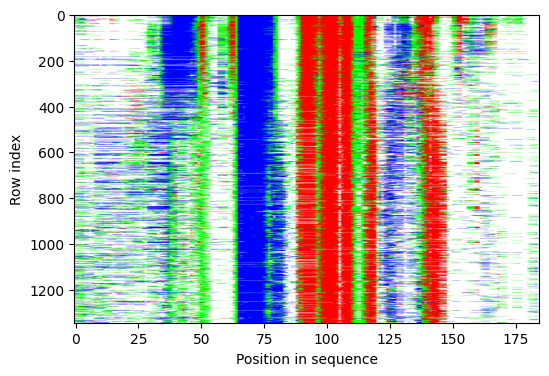

In [9]:
subset_df = subset_df.sort_values(by="z-score", ascending=False)
print(type(subset_df))
a=ISS_tools.visual.msa(subset_df,'sequ-pileup')
b=ISS_tools.visual.msa(subset_df,'dssp-pileup')
b.heatmap()

The common core is about half the size of the query structure. The matched proteins consistently align the same secondary structure elements.

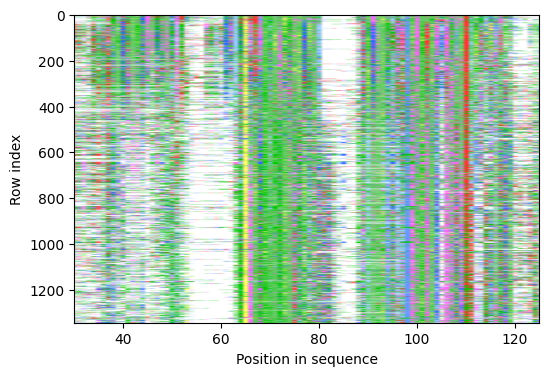

In [10]:
a.heatmap(left=30,right=125)

The sequence view shows vertical stripes at positions with strongly conserved amino acids.Sequence logos highlight these conserved positions.

<Figure size 1000x300 with 0 Axes>

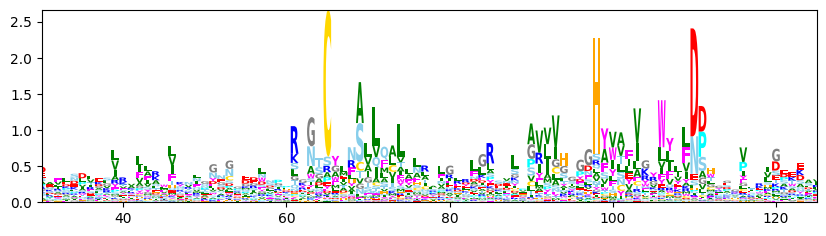

In [11]:
# Generating logos for large multiple sequence alignments can be slow.
a.logo(left=30,right=125)
#b.logo(left=30,right=125)

## Conserved sequence motif
The sequence logo showed a conserved C-H-D motif at positions 65, 98 and 110. This motif is also present in the query structure (data not shown).

The df.set_motif() method extracts the amino acids at the selected positions and keeps the most frequent ones while pooling the rest to group 'other'.

The visualization shows that the C-H-D motif is dominate over C-H-N among the highest scoring hits.

In [12]:
positions=[65,98,110]
df.set_motif(positions,k=2)
df.iscatter(color='motif',marker='TRUE',title='Conserved motifs: marker size is subjsct coverage',size='sbjct-coverage')


Frequent
motif
CHD    702
CHN    261
CSD     38
CHE     29
CLD     26
CAD     22
CHS     21
CRD     18
PHD     18
RPL     14
Name: count, dtype: int64

Selected
motif
other    739
CHD      702
CHN      261
Name: count, dtype: int64


## Novel findings in motif-matching subset
Let's create a new subset that matches the motif. Further, check which of those proteins are novel finding, i.e. not assigned to CL0125 by Pfam.

The C-H-D motif (and its variant C-H-E) suggest enzymatic activity of the novel findings.

In [13]:
pattern=['CHD','CHN']
motif_df = df.subset(df['motif'].isin(pattern)) 
motif_df.sort_values(by=['pfam', 'motif','clan'], inplace=True)
print(motif_df.shape[0],f" proteins contain the {pattern} motif")

963  proteins contain the ['CHD', 'CHN'] motif


In [14]:
novel_df = motif_df.subset(motif_df['TRUE']=='unassigned')
print(novel_df.shape[0],f" proteins outside the reference clan contain the {pattern} motif. These are novel findings.")
pd.set_option('display.max_colwidth', None)

47  proteins outside the reference clan contain the ['CHD', 'CHN'] motif. These are novel findings.


### Pfam domain composition of novel proteins
Utility function pfam_composition extracts all Pfam domain assignments for a list of proteins. Note that these domains can be located anywhere in the protein. This is in contrast to ISS_ProtSci's fragment based Pfam annotations, where we known that the annotation maps to a region that is structurally equivalent to the query.

In [15]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_colwidth')

## FASTA output for sequence tools
You may wish to use CD-HIT to derive a representative subset of proteins.

Sequence alignment tools are generally unable to reproduce the structural alignment of distantly related proteins. For example, mafft is unable to align the full sequences of the novel proteins correctly. However, mafft on pileup sequences preserves the invariant C-H-D columns.

In [16]:
novel_df.write_FASTA(seq_col='sequ-pileup',outfile='novel.fasta')

# Evaluation: comparing two sets of DALI hits
The function diff_df visualizes the overlap between the 'sbjct' columns of two dataframe objects, returning a DALIFrame object. 

Table 1 showed similar analysis performed automatically by ISS_ProtSci.

Overlap 'status' takes values 'both', 'first-only' or 'second-only'. If df1 containes the members of a Pfam clan and df2 is a set to be evaluated, the 'status' states would correspond to true-positives, false-negatives and false-positives, respectively.  However, if the second set has strong structural similarity to the query, they are potential discoveries that are misclassified in the reference classification.


In [17]:
# ordinary Pandas DataFrames, headerless input
TRUE_dali_df = ISS_tools.visual.read_dali_tsv(TRUE_CLAN_DALI_tsv)

Read 1468 rows with 14 columns from ../demo_data/pr80A.CL0125.TRUE.dali.tsv


status
both           1122
first-only      346
second-only     222
Name: count, dtype: int64


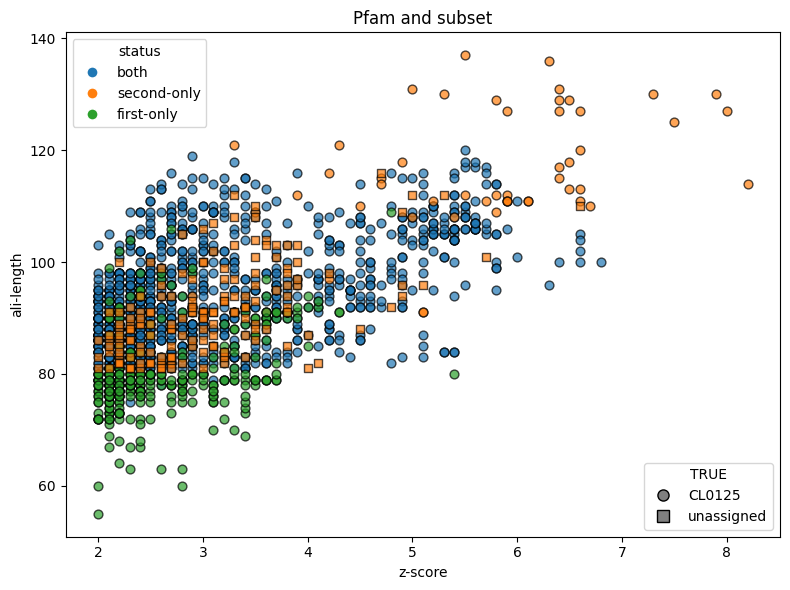

In [18]:
CLAN='CL0125'
x = ISS_tools.visual.diff_df(TRUE_dali_df,subset_df,CLAN,pf.TRUE_df,title='Pfam and subset')

# Save df to file 

In [19]:
subset_df.to_csv('subset.tsv',sep='\t',index=False)